In [1]:
# This script requires you to use a DESI kernel

%matplotlib inline
# matplotlib widget doesn't seem to work
# %matplotlib widget
import sys
import os
import pathlib
import math
import logging
import random
import numpy as np
import psycopg2
import psycopg2.extras
import pandas
from matplotlib import pyplot

from mosthosts_desi import MostHostsDesi
from desi_specfinder import TargetNotFound, SpectrumFinder

In [2]:
logger = logging.getLogger("main")
ch = logging.StreamHandler(sys.stderr)
logger.addHandler(ch)
formatter = logging.Formatter(
    f"[%(asctime)s - %(levelname)s] - %(message)s"
)
ch.setFormatter(formatter)
logger.setLevel( logging.INFO )

In [3]:
# Replace these next two lines with something that sets dbuser and dbpasswd to the
#  right value.  It can be as simple as
#    dbuser = 'desi'
#    dbpasswd = '...'
#  with the right thing in place of ...
#  (Just don't save the password to a public git archive.)
with open( pathlib.Path(os.getenv("HOME")) / "secrets/decatdb_desi_desi" ) as ifp:
    (dbuser, dbpasswd) = ifp.readline().strip().split()
    
# Read in the MostHosts data with info on what's been observed by desi
# Do help(MostHostsDesi) for more information.  This defaults to looking
# at daily spectra; look at a specific release by using the release keyword.
# If you've run this before, it will cache the results in a .pkl file in
# your current directory.  Add force_regen=True to make it to back and
# reload the database (which makes sense for daily).
mosthosts = MostHostsDesi( dbuser=dbuser, dbpasswd=dbpasswd, logger=logger, release='daily', force_regen=True )

[2023-01-06 13:17:05,351 - INFO] - Loading mosthosts table...
[2023-01-06 13:17:06,050 - INFO] - ...mosthosts table loaded.
[2023-01-06 13:17:06,051 - INFO] - Rebuilding info for release daily
[2023-01-06 13:17:06,059 - INFO] - Sending q3c_join query for release daily
[2023-01-06 13:17:06,365 - INFO] - ...temporary table has 7928 rows, 7928 including a desi observation.
[2023-01-06 13:17:06,365 - INFO] - Getting night/redshift/type info
[2023-01-06 13:17:06,613 - INFO] - ...done getting night/redshift/type info, got 9406 rows.
[2023-01-06 13:17:06,929 - INFO] - 7135 of 9406 redshifts left after keeping only latest night
[2023-01-06 13:17:06,929 - INFO] - Building hazdf...
[2023-01-06 13:17:07,046 - INFO] - Building df...
[2023-01-06 13:17:12,465 - INFO] - Done generating dataframes.
[2023-01-06 13:17:12,937 - INFO] - mosthosts_desi_daily.csv and mosthosts_desi_daily_desiobs.csv written.


In [20]:
# Which SN do we want to look at?  Make it None to choose a random one.
# This name has to match the name used in SkyPortal (TNS name first,
# then IAU name if TNS doesn't exist, then PTFIPTF if IAU doesn't
# exist, then whatever's in the snname field.  This is what is in
# the "spname" index of mosthosts.df and mosthosts.haszdf.)
sntoshow = '10rct'
# sntoshow = None

if sntoshow is None:
    sne = mosthosts.haszdf.index.unique( level=0 )
    dex = random.randint(0, len(sne)-1)
    spname = sne[dex]
else:
    spname = sntoshow

logger.info( f'Going to look at spectra for {spname}' )


[2023-01-06 13:42:23,986 - INFO] - Going to look at spectra for 10rct


In [23]:
# The supernova name didn't match what was on skyportal!
# Do a search to try to find it
ar = list(mosthosts.haszdf.index.get_level_values(0))
import re
for a in ar:
    if re.search('10rct', a):
        print(a)


10rct
10rct


In [24]:
# Play some grouping games with Pandas to get the list of RAs and Decs out of the MostHostsDesi data frames
# to pass to SpectrumFinder

sub = mosthosts.haszdf.loc[ spname, : ]
tmp = sub.reset_index().groupby("index")['night'].count()
print( f'There are {len(tmp)} hosts with 1 or more desi spectra.' )
for index,num in zip( tmp.index, tmp ):
    print( f'{num} hosts for {sntoshow} Host {index}' )
tmp = sub.reset_index().groupby("index")['index', 'ra', 'dec'].first()

names = [ f"{sntoshow} Host {index}" for index in tmp['index'] ]
specinfo = SpectrumFinder( tmp['ra'], tmp['dec'], names=names, desipasswd=dbpasswd, collection='daily' )
print( f'Found {len(specinfo.targetids)} targets: {specinfo.targetids}' )

# display(sub)
# display( specinfo._tiledata )

for name in names:
    targids = specinfo.targetids_for_name(name)
    print( f"\nTargets for {name}:" )
    for tid in targids:
        infos = specinfo.info_for_targetid( tid )
        for info in infos:
            print( f"    Target {tid:20d}, tileid {info['tileid']:6d}, petal {info['petal_loc']:1d}, night {info['night']:8d}" )

/tmp/ipykernel_260388/3659238251.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = sub.reset_index().groupby("index")['index', 'ra', 'dec'].first()
[2023-01-06 13:42:40,933 - INFO] - Looking for daily spectra at 1 positions w/in 0.0002777777777777778°.)
[2023-01-06 13:42:40,934 - DEBUG] - Search table:
               name         ra       dec
index                                   
1      10rct Host 1  32.950663  13.15537
[2023-01-06 13:42:40,962 - DEBUG] - Filling temporary table...
[2023-01-06 13:42:40,969 - DEBUG] - ...filled.
[2023-01-06 13:42:40,970 - DEBUG] - Filling second temporary table...
[2023-01-06 13:42:40,976 - DEBUG] - ...filled


There are 1 hosts with 1 or more desi spectra.
2 hosts for 10rct Host 1
Found 1 targets: {2842841856344069}

Targets for 10rct Host 1:
    Target     2842841856344069, tileid   3276, petal 6, night 20211030
    Target     2842841856344069, tileid   6418, petal 3, night 20221219


In [25]:
mosthosts.haszdf.xs(sntoshow, level=0)

ra       dec  pmra  \
index targetid         tileid petal night                                 
1     2842841856344069 3276   6     20211030  32.950663  13.15537   0.0   
                       6418   3     20221219  32.950663  13.15537   0.0   

                                              pmdec  ref_epoch  override  \
index targetid         tileid petal night                                  
1     2842841856344069 3276   6     20211030    0.0        0.0     False   
                       6418   3     20221219    0.0        0.0     False   

                                             hemisphere      sn_ra    sn_dec  \
index targetid         tileid petal night                                      
1     2842841856344069 3276   6     20211030      south  32.949104  13.15326   
                       6418   3     20221219      south  32.949104  13.15326   

                                               sn_z  ... iau_name  \
index targetid         tileid petal night            ...            
1     2842841856344069 3276   6     20211030  0.076  ...     None   
                       6418   3     20221219  0.076  ...     None   

                                              ptfiptf_name    spname  \
index targetid         tileid petal night                              
1     2842841856344069 3276   6     20211030      PTF10rct  PTF10rct   
                       6418   3     20221219      PTF10rct  PTF10rct   

                                                     z     zerr zwarn  \
index targetid         tileid petal night                               
1     2842841856344069 3276   6     20211030  0.078025  0.00001     0   
                       6418   3     20221219  0.078020  0.00001     0   

                                                      chi2     deltachi2  \
index targetid         tileid petal night                                  
1     2842841856344069 3276   6     20211030  17604.605992  34056.487993   
                       6418   3     20221219  15901.990562  26371.669469   

                                              spectype  subtype  
index targetid         tileid petal night                        
1     2842841856344069 3276   6     20211030    GALAXY           
                       6418   3     20221219    GALAXY           

[2 rows x 23 columns]


Targets for ZTF18accepsq Host 1:
INFO:spectra.py:291:read_spectra: iotime 0.271 sec to read coadd-2-6519-thru20221028.fits at 2023-01-04T12:00:57.359209


/tmp/ipykernel_155657/2038698129.py:35: RuntimeWarning: divide by zero encountered in true_divide
  noise = np.sqrt( 1. / spec.ivar['brz'][0, :] )



Targets for ZTF18accepsq Host 2:
INFO:spectra.py:291:read_spectra: iotime 0.219 sec to read coadd-2-6519-thru20221028.fits at 2023-01-04T12:00:57.788112


/tmp/ipykernel_155657/2038698129.py:35: RuntimeWarning: divide by zero encountered in true_divide
  noise = np.sqrt( 1. / spec.ivar['brz'][0, :] )


INFO:spectra.py:291:read_spectra: iotime 0.261 sec to read coadd-8-22378-thru20220601.fits at 2023-01-04T12:00:58.345283

Targets for ZTF18accepsq Host 3:
INFO:spectra.py:291:read_spectra: iotime 0.218 sec to read coadd-8-22378-thru20220601.fits at 2023-01-04T12:00:58.790326


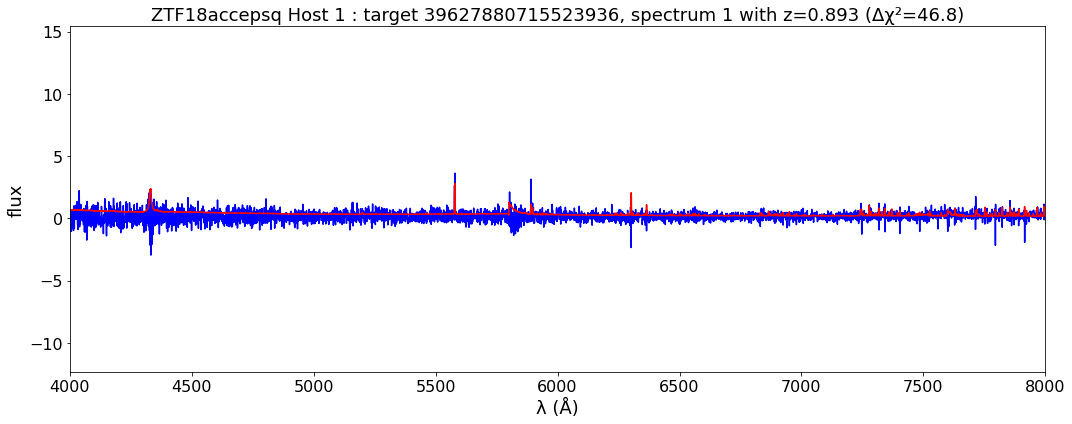

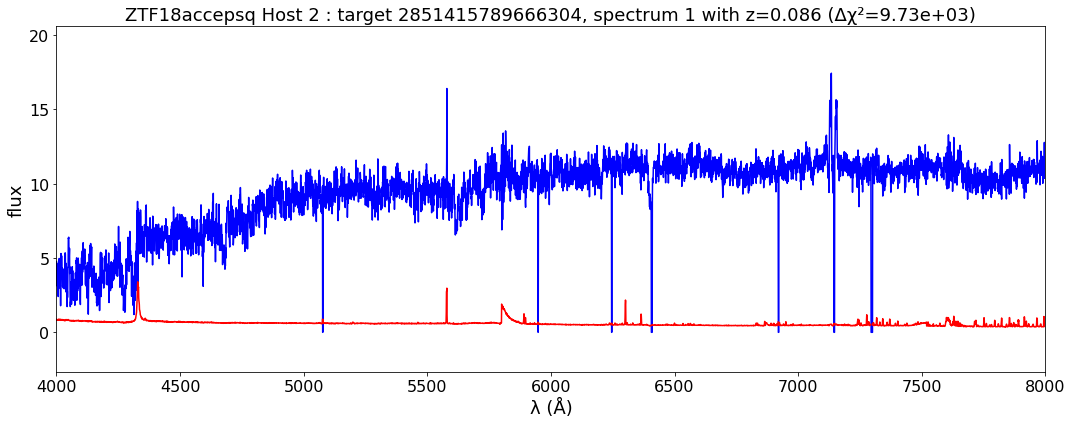

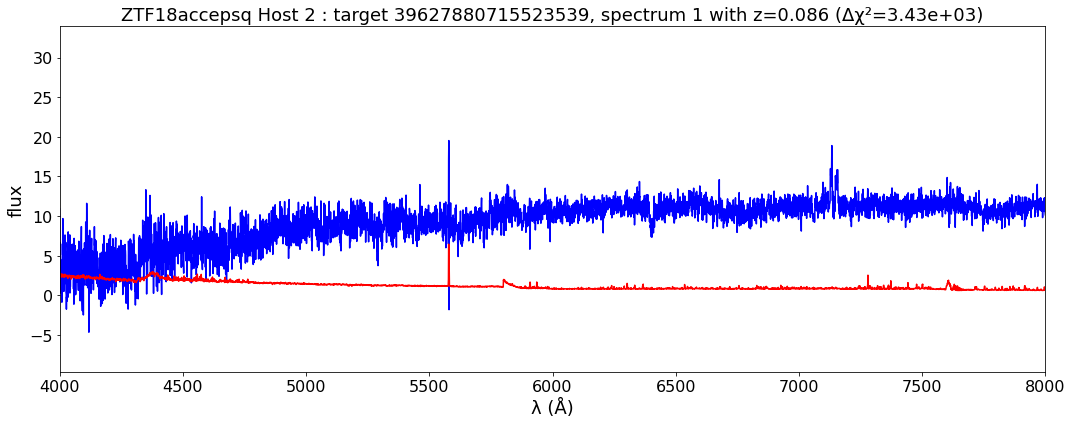

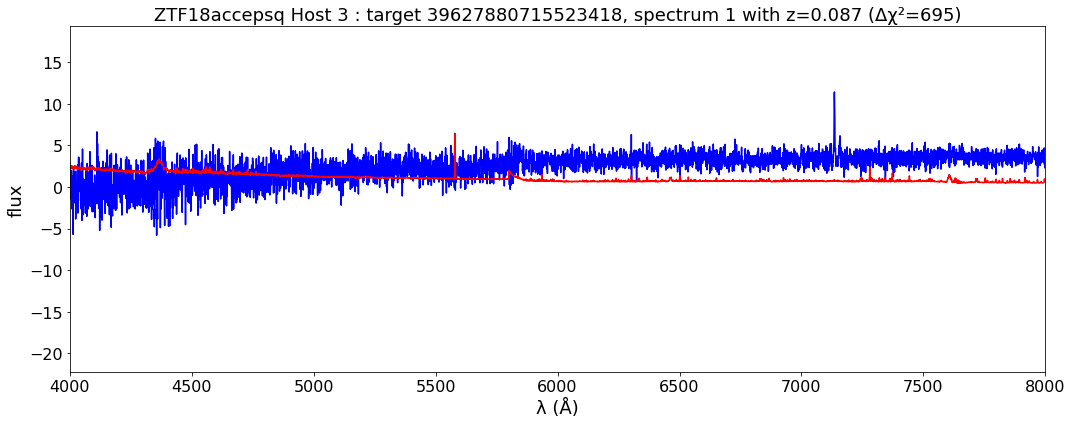

In [14]:
# Plot limits.  Make them None to autoscale
fmin = None
fmax = None
λmin = 4000
λmax = 8000
gausssmooth = 2

for name in names:
    targids = specinfo.targetids_for_name(name)
    print( f"\nTargets for {name}:" )
    for tid in targids:
        infos = specinfo.info_for_targetid( tid )
        specs = specinfo.get_spectra( tid )
        specnum = 0
        for info, spec in zip( infos, specs ):
            specnum += 1
            fig = pyplot.figure( figsize=(15,6), tight_layout=True )
            ax = fig.add_subplot( 1, 1, 1 )
            title = ( f'{name} : target {tid}, spectrum {specnum} '
                      # f'Tile {spec["tileid"]} on night {spec["night"]} '
                      f'with z={info["z"]:.3f}' )
            if info["zwarn"] != 0:
                title += f' (zwarn={info["zwarn"]})'
            title += f' (Δχ²={info["deltachi2"]:.3g})'
            ax.set_title( title, fontsize=18 )
            ax.set_xlabel( 'λ (Å)', fontsize=18 )
            ax.set_ylabel( 'flux', fontsize=18 )
            ax.tick_params( axis='both', labelsize=16 )
            if λmin is not None:
                ax.set_xlim( λmin, λmax )
            if fmin is not None:
                ax.set_ylim( fmin, fmax )
            λ = spec.wave['brz']
            flux = spec.flux['brz'][0, :]
            noise = np.sqrt( 1. / spec.ivar['brz'][0, :] )
            
            ax.plot( λ, flux, 'b' )
            ax.plot( λ, noise, 'r' )
            fig.show()


In [21]:
targids = specinfo.targetids_for_name( names[1] )
sys.stderr.write( f"Getting spectrum for second tid of {len(targids)} for {names[1]}\n" )
tid = list(targids)[1]
specs = specinfo.get_spectra( tid )
sys.stderr.write( f"There are {len(specs)} spectra, getting the first\n" )
spec = specs[ 0 ]
with open( "spectrum.csv", "w" ) as ofp:
    ofp.write( "wavelength,flux,dflux\n" )
    for i in range( len(spec.wave['brz'] ) ):
        noise = 1. / math.sqrt( spec.ivar['brz'][0, i] )
        ofp.write( f"{spec.wave['brz'][i]},{spec.flux['brz'][0,i]},{noise}\n" )


Getting spectrum for second tid of 2 for ZTF18accepsq Host 2


INFO:spectra.py:291:read_spectra: iotime 0.202 sec to read coadd-8-22378-thru20220601.fits at 2023-01-04T12:07:11.465095


There are 1 spectra, getting the first


In [23]:
mosthosts.df.loc['ZTF18accepsq',2]

ra                322.914765
dec                 3.863727
pmra                     0.0
pmdec                    0.0
ref_epoch                0.0
override               False
hemisphere             south
sn_ra             322.924097
sn_dec              3.850465
sn_z                 -9999.0
program               SNe_Ia
priority                 5.0
tns_name                None
iau_name                None
ptfiptf_name            None
spname          ZTF18accepsq
z                   0.086292
zerr                 0.00001
zdisp               0.000023
Name: (ZTF18accepsq, 2), dtype: object